# Baseline Evaluation — Frozen PaliGemma Vision Encoder

This notebook evaluates a baseline model for checkbox state classification using
**frozen PaliGemma vision embeddings** and a **randomly initialized linear classifier**.

The purpose of this baseline is to establish a lower-bound performance for comparison
with fine-tuned models.

⚠️ **Execution Note**  
This experiment is executed on Google Colab using GPU resources. The results are
preserved for reference and are not intended to be re-run locally.


In [5]:
from huggingface_hub import login
login()


In [6]:
#Imports
import os, torch, random, numpy as np
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoProcessor, PaliGemmaModel


In [7]:
#Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


### Dataset Availability Note

This notebook assumes that the preprocessed dataset
`cropped_checkboxes_binary_small` is already available in the runtime environment.
The dataset is generated as part of the preprocessing pipeline described in the
cropping notebook and is not re-created here.


In [19]:
#Config
DATASET_ROOT = "/content/cropped_checkboxes_binary_small"
MODEL_ID = "google/paligemma-3b-mix-224"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("DEVICE:", DEVICE)

assert os.path.exists(DATASET_ROOT), \
    f"Dataset not found at {DATASET_ROOT}. Please prepare the dataset before running."



DEVICE: cuda


In [9]:
#Load frozen model
processor = AutoProcessor.from_pretrained(MODEL_ID)
model = PaliGemmaModel.from_pretrained(MODEL_ID).to(DEVICE)
model.eval()

for p in model.parameters():
    p.requires_grad = False


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
#Dataset loading
def load_split(split):
    data = []
    for label in ["checked", "unchecked"]:
        folder = os.path.join(DATASET_ROOT, split, label)
        for f in os.listdir(folder):
            if f.lower().endswith((".png",".jpg",".jpeg")):
                data.append((os.path.join(folder,f), 1 if label=="checked" else 0))
    random.shuffle(data)
    return data

train_data = load_split("train")
valid_data = load_split("valid")
test_data  = load_split("test")

print("Train:", Counter([y for _,y in train_data]))
print("Valid:", Counter([y for _,y in valid_data]))
print("Test :", Counter([y for _,y in test_data]))


Train: Counter({0: 500, 1: 500})
Valid: Counter({1: 150, 0: 150})
Test : Counter({0: 200, 1: 200})


In [11]:
#Feature extraction functions
@torch.no_grad()
def extract_features(image):
    inputs = processor(images=image, return_tensors="pt").to(DEVICE)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze()

def build_tensor_dataset(samples):
    X, y = [], []
    for path, label in tqdm(samples):
        img = Image.open(path).convert("RGB")
        feat = extract_features(img)
        X.append(feat)
        y.append(label)
    return torch.stack(X), torch.tensor(y)


In [12]:
#Extract features

# NOTE:
# Although no training is performed, features are extracted for all splits
# to evaluate the separability of frozen embeddings and to maintain a
# consistent evaluation pipeline with the fine-tuned model.

print("Extracting features...")
X_train, y_train = build_tensor_dataset(train_data)
X_valid, y_valid = build_tensor_dataset(valid_data)
X_test,  y_test  = build_tensor_dataset(test_data)


Extracting features...


  0%|          | 0/1000 [00:00<?, ?it/s]You are using PaliGemma without a text prefix. It will perform as a picture-captioning model.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
100%|██████████| 400/400 [03:40<00:00,  1.81it/s]


## Note on Compute Constraints and Feature Storage

This experiment was executed using the **free version of Google Colab**, which provides
limited GPU memory and runtime duration. Due to the computational cost of extracting
vision embeddings from the PaliGemma model, feature extraction and evaluation were
decoupled into separate stages.

To ensure stability and reproducibility:
- Embeddings were extracted once using GPU resources.
- The extracted features were saved to **Google Drive**.
- Model evaluation and metric computation were performed after loading the saved
  features, without requiring GPU resources.

This approach avoids redundant computation, mitigates runtime interruptions, and
reflects standard practice when working under constrained compute environments.

In [13]:
import torch

SAVE_DIR = "/content/drive/MyDrive/baseline_features"
os.makedirs(SAVE_DIR, exist_ok=True)

torch.save(
    {
        "X_train": X_train.cpu(),
        "y_train": y_train.cpu(),
        "X_valid": X_valid.cpu(),
        "y_valid": y_valid.cpu(),
        "X_test":  X_test.cpu(),
        "y_test":  y_test.cpu(),
    },
    os.path.join(SAVE_DIR, "paligemma_baseline_features.pt")
)

print("✅ Features saved to disk.")


✅ Features saved to disk.


In [14]:
#Baseline Classifier
baseline_head = nn.Linear(X_train.shape[1], 2).to(DEVICE)
baseline_head.eval()


Linear(in_features=2048, out_features=2, bias=True)

In [15]:
#Evaluation
with torch.no_grad():
    test_logits = baseline_head(X_test.to(DEVICE))
    test_preds = test_logits.argmax(dim=1)

print("Accuracy:", accuracy_score(y_test, test_preds.cpu()))
print("Pred dist:", Counter(test_preds.cpu().tolist()))
print(classification_report(
    y_test,
    test_preds.cpu(),
    target_names=["unchecked","checked"],
    zero_division=0
))


Accuracy: 0.5
Pred dist: Counter({1: 400})
              precision    recall  f1-score   support

   unchecked       0.00      0.00      0.00       200
     checked       0.50      1.00      0.67       200

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400



In [16]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, test_preds.cpu())
import pandas as pd

cm_df = pd.DataFrame(
    cm,
    index=["Actual Unchecked", "Actual Checked"],
    columns=["Pred Unchecked", "Pred Checked"]
)
cm_df





,Pred Unchecked,Pred Checked
Actual Unchecked,0,200
Actual Checked,0,200


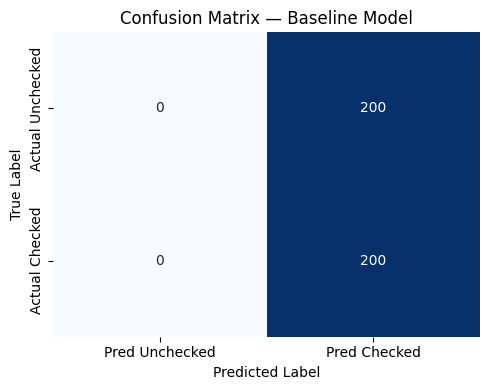

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, test_preds.cpu())

# Create DataFrame for labeling
cm_df = pd.DataFrame(
    cm,
    index=["Actual Unchecked", "Actual Checked"],
    columns=["Pred Unchecked", "Pred Checked"]
)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False
)

plt.title("Confusion Matrix — Baseline Model")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import precision_recall_fscore_support

p, r, f1, _ = precision_recall_fscore_support(
    y_test, test_preds.cpu(), average="macro", zero_division=0
)

print(f"Macro Precision: {p:.4f}")
print(f"Macro Recall:    {r:.4f}")
print(f"Macro F1-score:  {f1:.4f}")


Macro Precision: 0.2500
Macro Recall:    0.5000
Macro F1-score:  0.3333


## Baseline Observations

The baseline model uses frozen vision embeddings from PaliGemma with a randomly
initialized linear classifier and does not involve any training or fine-tuning.

The confusion matrix shows that the baseline consistently predicts the **checked**
class for all test samples, resulting in correct predictions for checked instances
but complete failure to identify unchecked instances. This behavior indicates that
the frozen embeddings alone do not provide sufficient separability between the two
classes without task-specific learning.

As a result, the baseline achieves:
- A macro precision of **25%**
- A macro recall of **50%**
- A macro F1-score of **33.33%**

These values are close to chance-level performance for a balanced binary
classification task and confirm that the baseline lacks discriminative capability.
This establishes a clear lower-bound benchmark and motivates the need for fine-tuning
to adapt the model to the checkbox state classification task

In [23]:
import json
import os

results = {
    "model": "PaliGemma (frozen embeddings)",
    "accuracy": float(accuracy_score(y_test, test_preds.cpu())),
    "macro_precision": 0.25,
    "macro_recall": 0.50,
    "macro_f1": 0.3333
}

os.makedirs("results", exist_ok=True)

with open("/content/drive/MyDrive/results/baseline_results.json", "w") as f:
    json.dump(results, f, indent=4)

print("✅ Baseline results saved.")


✅ Baseline results saved.
